## 波形の読み込み

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utills.datapath as dpath

# 被験者データ
tester = dpath.LMH.H003.value.st_center

# pandasでcsvを読み込み
wave = pd.read_csv(".."/tester.value/"wave.csv", names=["L", "R", "L_gain", "R_gain"])
posture = pd.read_csv(".."/tester.value/"position.csv")

lraw = wave['L'].to_numpy()
rraw = wave['R'].to_numpy()
lgain = wave['L_gain'].to_numpy()
rgain = wave['R_gain'].to_numpy()
posture = posture.to_numpy()

left = lraw * 2.818 ** lgain
right = rraw * 2.818 ** rgain

# left = left[128*start: 128*end]
# right = right[128*start:128*end]

# 波形を見る

iter :  0


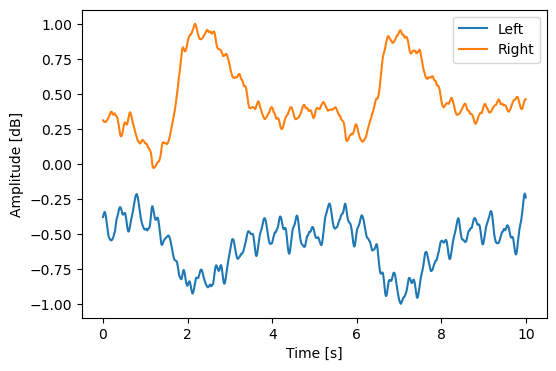

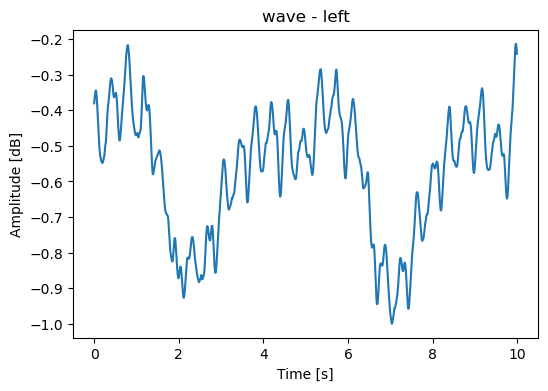

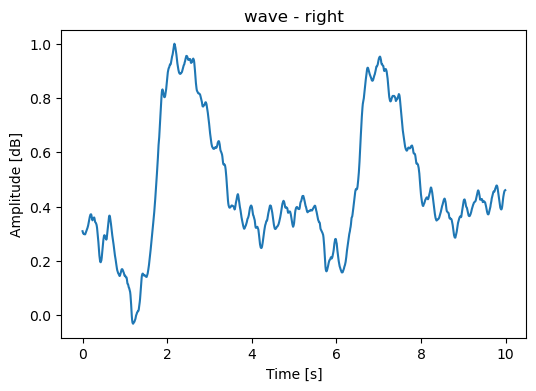

In [3]:
import matplotlib.pyplot as plt
import utills.preprocess as pp
from gmrf.x64.Release import gmrf
from cutill.x64.Release import cutill as c

start = 120
end = start + 10

left_part = left[128*start:128*end]
right_part = right[128*start:128*end]

left_part, right_part = c.normalize(left_part, right_part)
lg = gmrf.dvgmrf.dvgmrf()
rg = gmrf.dvgmrf.dvgmrf()

lg._lambda = 1e-11
lg._lambda_rate = 1e-13
lg._alpha = 1e-15
lg._alpha_rate = 1e-18
lg._epoch = 1000
lg.set_eps(1e-12)

rg = lg

left_denoised = lg.denoise([left_part])
right_denoised = rg.denoise([right_part])
print("iter : ", lg._epoch)

pp.wave_plot(left_part, right_part, title=None)
pp.wave_plot(left_part, title='wave - left')
pp.wave_plot(right_part, title='wave - right')

## スペクトログラムによる解析
STFTは短時間フーリエ変換 (short-time fourier transform : STFT) と呼ばれる解析手法。  
元の信号を短い窓で区切り、窓関数と通して解析した周波数を縦軸、横軸を時間にとった周波数スペクトグラムを見る。  

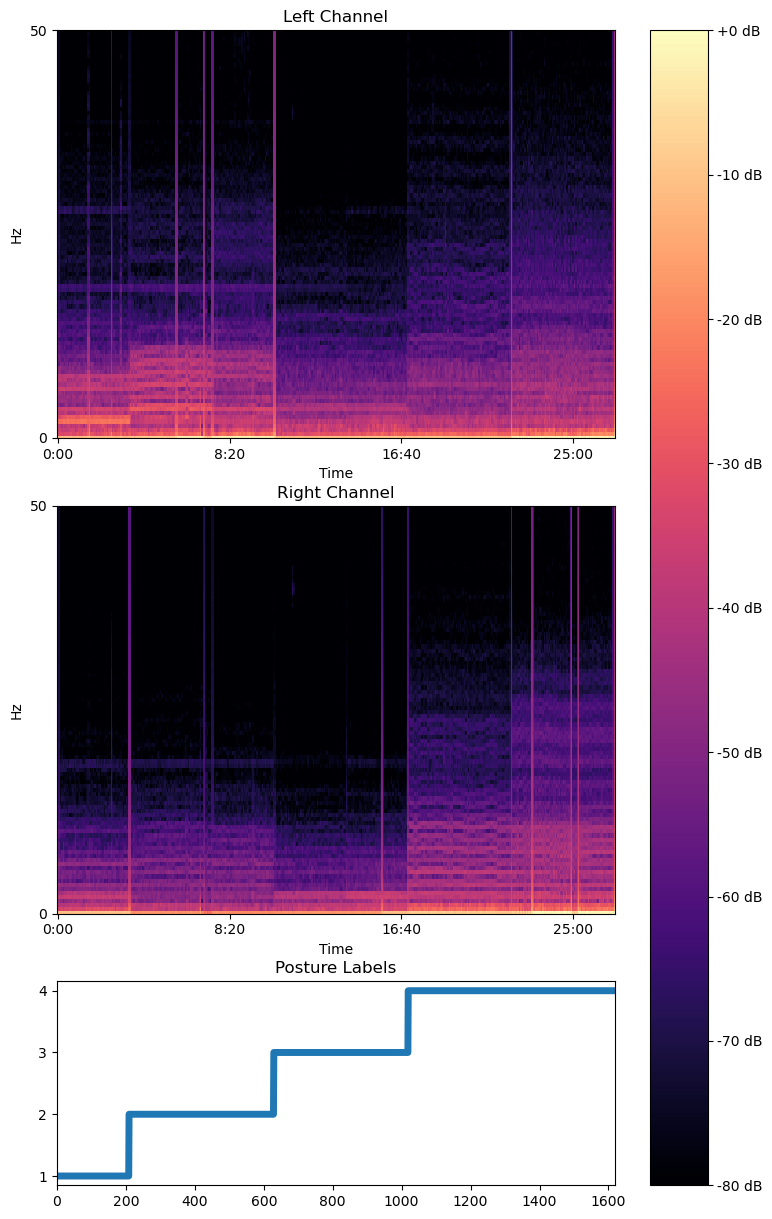

In [4]:
import librosa
import librosa.display
from matplotlib.ticker import MaxNLocator

# ハイパパラメータ
sr = 128    # サンプリング周波数

# スペクトログラムに変換(left)
left_S = librosa.feature.melspectrogram(y=left, sr=sr, n_fft=sr*20, win_length=sr*10, hop_length=sr*4)
left_S = librosa.power_to_db(abs(left_S), ref=np.max)

# スペクトログラムに変換(right)
right_S = librosa.feature.melspectrogram(y=right, sr=sr, n_fft=sr*20, win_length=sr*10, hop_length=sr*4)
right_S = librosa.power_to_db(abs(right_S), ref=np.max)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 15), 
                                     gridspec_kw={'height_ratios': [3, 3, 1.5]})

# 左チャンネルのスペクトログラム
img1 = librosa.display.specshow(left_S, x_axis="time", y_axis="mel", sr=sr, ax=ax1)
ax1.set_title("Left Channel")
ax1.set_ylim(0, 50)

# 右チャンネルのスペクトログラム
img2 = librosa.display.specshow(right_S, x_axis="time", y_axis="mel", sr=sr, ax=ax2)
ax2.set_title("Right Channel")
ax2.set_ylim(0, 50)

# 姿勢ラベルの表示
ax3.plot(np.arange(0, len(posture)), posture, lw=5)
ax3.set_title("Posture Labels")
ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
ax3.set_xlim(0, len(posture))

# 共通のカラーバーを追加
fig.colorbar(img2, ax=[ax1, ax2, ax3], format='%+2.0f dB')

# レイアウトを調整して表示
fig.savefig("../images/mel_spectgrum.png", bbox_inches="tight")
plt.show()

## スペクトログラムによる解析
周波数分解能を高めるために、1280点で切り出した波形をゼロパディングして2560点でfftします。

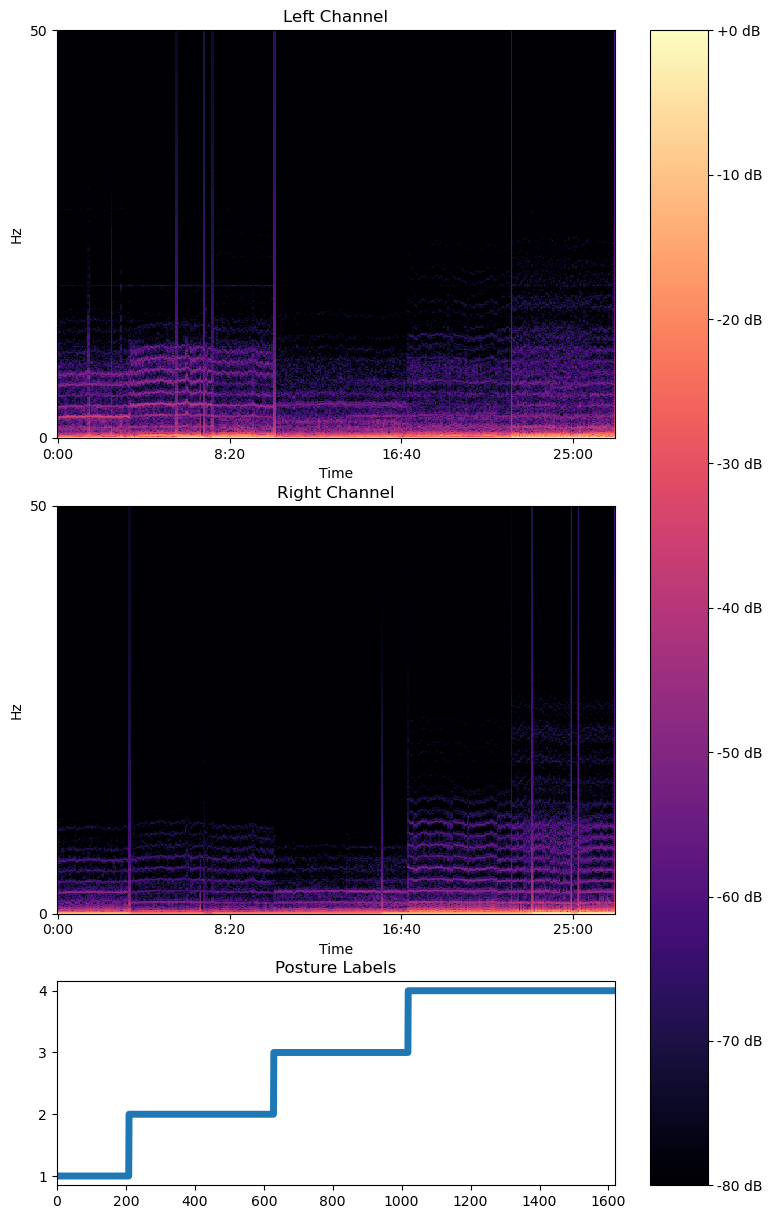

In [5]:
import librosa
import librosa.display
from matplotlib.ticker import MaxNLocator

# ハイパパラメータ
sr = 128    # サンプリング周波数

# スペクトログラムに変換(left)
left_S = librosa.stft(y=left, n_fft=sr*20, win_length=sr*10, hop_length=sr*4)
left_S = librosa.amplitude_to_db(abs(left_S), ref=np.max)
left_f0 = librosa.yin(y=left, fmin=0.5, fmax=32)
    

# スペクトログラムに変換(right)
right_S = librosa.stft(y=right, n_fft=sr*20, win_length=sr*10, hop_length=sr*4)
right_S = librosa.amplitude_to_db(abs(right_S), ref=np.max)
right_f0 = librosa.yin(y=right, fmin=0.5, fmax=32)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 15), 
                                     gridspec_kw={'height_ratios': [3, 3, 1.5]})

# 左チャンネルのスペクトログラム
img1 = librosa.display.specshow(left_S, x_axis="time", y_axis="log", sr=sr, ax=ax1)
# ax1.plot(left_f0, label='f0')
ax1.set_title("Left Channel")
ax1.set_ylim(0, 50)

# 右チャンネルのスペクトログラム
img2 = librosa.display.specshow(right_S, x_axis="time", y_axis="log", sr=sr, ax=ax2)
ax2.set_title("Right Channel")
ax2.set_ylim(0, 50)

# 姿勢ラベルの表示
ax3.plot(np.arange(0, len(posture)), posture, lw=5)
ax3.set_title("Posture Labels")
ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
ax3.set_xlim(0, len(posture))

# 共通のカラーバーを追加
fig.colorbar(img2, ax=[ax1, ax2, ax3], format='%+2.0f dB')

# レイアウトを調整して表示
fig.savefig("../images/spectgrum.png", bbox_inches="tight")
plt.show()

## constant-Q変換による解析

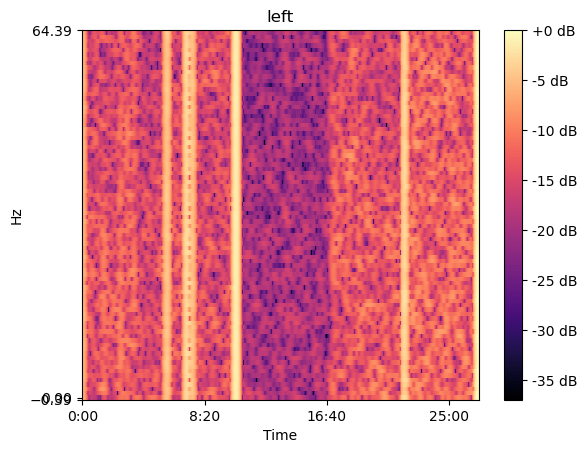

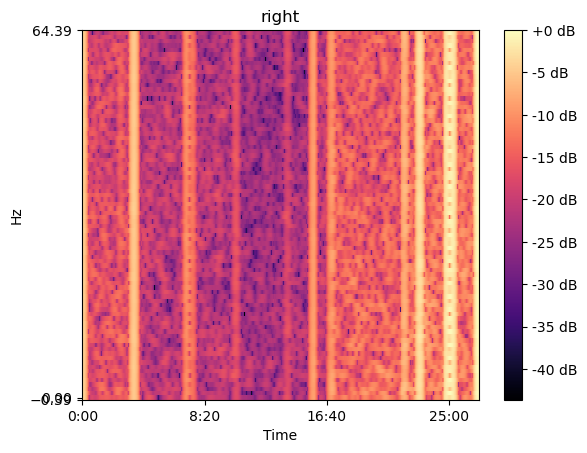

In [6]:
import librosa
import librosa.display

# ハイパパラメータ
sr = 128    # サンプリング周波数

# スペクトグラムに変換(left)
S = librosa.cqt(y=left, sr=sr, hop_length=512, bins_per_octave=1280)
S = abs(S)
S = librosa.power_to_db(S, ref=np.max)

img = librosa.display.specshow(S, x_axis="time", y_axis="mel", sr=sr)
plt.colorbar(img, format='%+2.0f dB')
plt.title("left")
plt.show()

# スペクトグラムに変換(right)
S = librosa.cqt(y=right, sr=sr, hop_length=512, bins_per_octave=1280)
S = abs(S)
S = librosa.power_to_db(S, ref=np.max)

img = librosa.display.specshow(S, x_axis="time", y_axis="mel", sr=sr)
plt.colorbar(img, format='%+2.0f dB')
plt.title("right")
plt.show()

# ケプストラム領域の比較
周波数とメル周波数からケプストラムに変換した結果を確認したい。

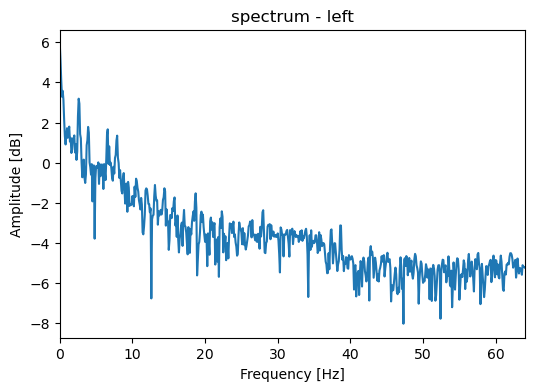

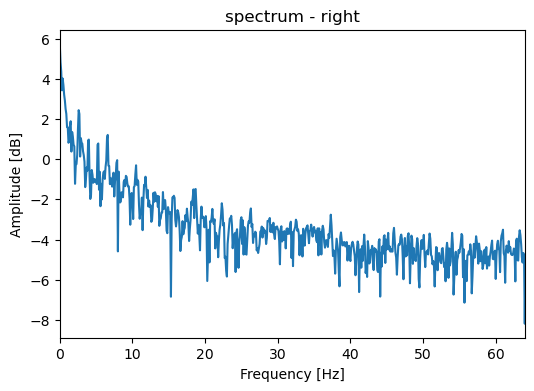

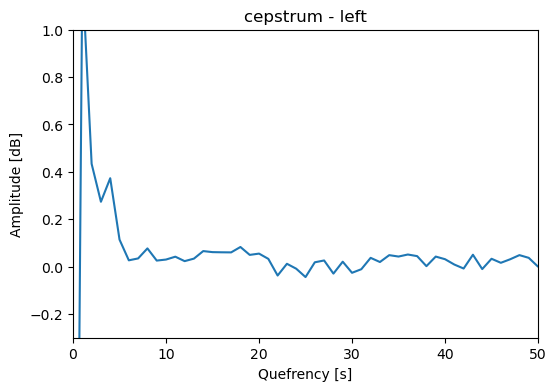

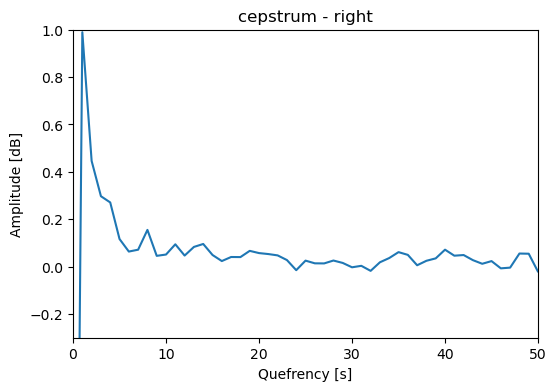

c:\ProgramData\Anaconda3\envs\satou\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\ProgramData\Anaconda3\envs\satou\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


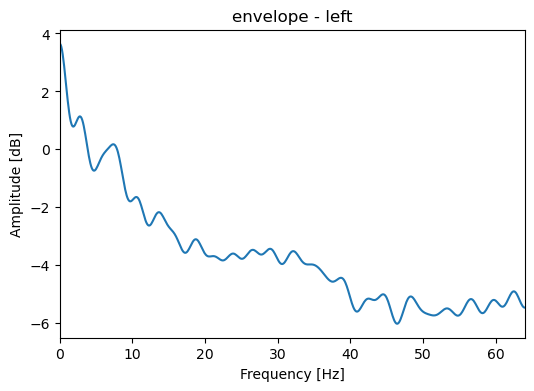

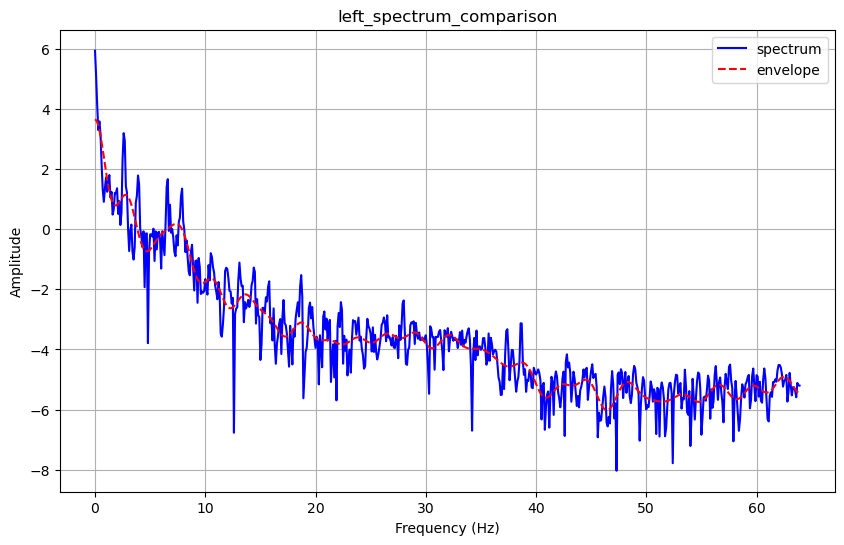

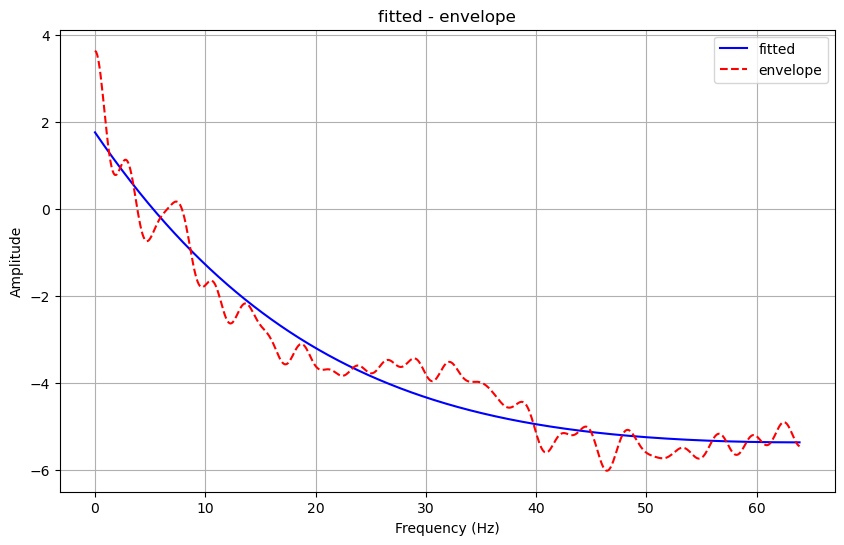

In [7]:
wave_l, wave_r = left_part, right_part
wave_l, wave_r = c.normalize(wave_l, wave_r)
han = np.hanning(len(wave_l))     # ハン窓
wave_l *= han
wave_r *= han
spectrum_l, spectrum_r = np.abs(np.fft.fft(wave_l)), np.abs(np.fft.fft(wave_r))
spectrum_l, spectrum_r = np.log(spectrum_l), np.log(spectrum_r)

spectrum_l_fitted = spectrum_l - pp.fit_polynomial(spectrum_l, 4)
spectrum_r_fitted = spectrum_r - pp.fit_polynomial(spectrum_r, 4)

# spectrum_l[0:10] *= scale
# spectrum_r[0:10] *= scale

# ケプストラムに変換
cepstrum_l = np.fft.ifft(spectrum_l).real
cepstrum_r = np.fft.ifft(spectrum_r).real

cutoff = 50
bandPathLifter = 'low'
scale = 1e-10
if bandPathLifter == 'high':
    cepstrum_l[:cutoff] *= scale
    cepstrum_l[len(cepstrum_l)-cutoff-1:] *= scale
elif bandPathLifter == 'low':
    cepstrum_l[cutoff:len(cepstrum_l)-cutoff+1] *= scale

cep_to_spectrum_l = np.fft.fft(cepstrum_l)
# cep_to_spectrum_l[0:10] *= scale

plt.figure(figsize=(6, 4))
plt.plot(np.arange(0, 128, 0.1), spectrum_l)
plt.title("spectrum - left")
plt.xlim(0, len(spectrum_l)//20)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(np.arange(0, 128, 0.1), spectrum_r)
plt.title("spectrum - right")
plt.xlim(0, len(spectrum_l)//20)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(np.arange(0, 1280), cepstrum_l.real)
plt.xlim(0, 50)
plt.ylim(-0.3, 1.0)
plt.title("cepstrum - left")
plt.xlabel('Quefrency [s]')
plt.ylabel('Amplitude [dB]')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(np.arange(0, 1280), cepstrum_r.real)
plt.xlim(0, 50)
plt.ylim(-0.3, 1.0)
plt.title("cepstrum - right")
plt.xlabel('Quefrency [s]')
plt.ylabel('Amplitude [dB]')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(np.arange(0, 128, 0.1), cep_to_spectrum_l)
plt.title("envelope - left")
plt.xlim(0, len(cep_to_spectrum_l)//20)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.show()

pp.freq_plot(spectrum_l, cep_to_spectrum_l, 128, title='left_spectrum_comparison', legend=['spectrum', 'envelope'])
pp.freq_plot(spectrum_l-pp.fit_polynomial(spectrum_l, 4) if bandPathLifter == 'high' else pp.fit_polynomial(spectrum_l, 4), 
             cep_to_spectrum_l, 128, title='fitted - envelope', legend=['fitted', 'envelope'])

# クロススペクトル

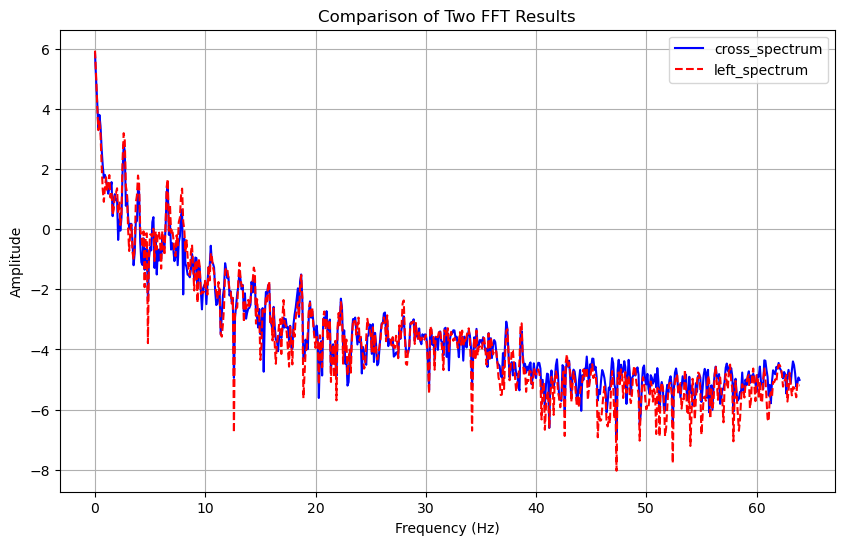

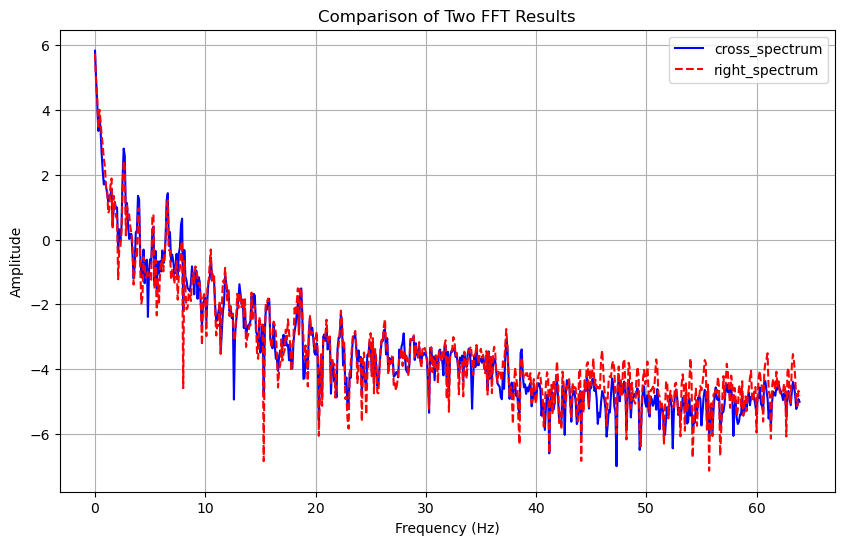

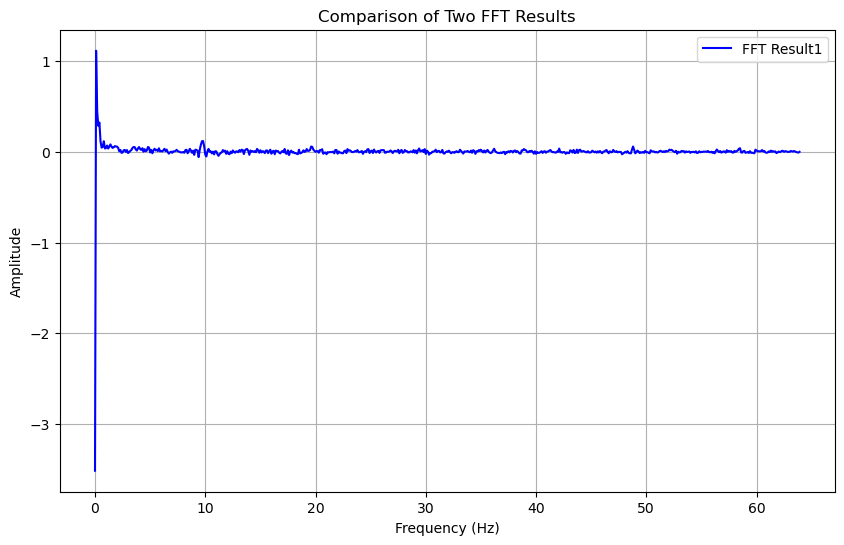

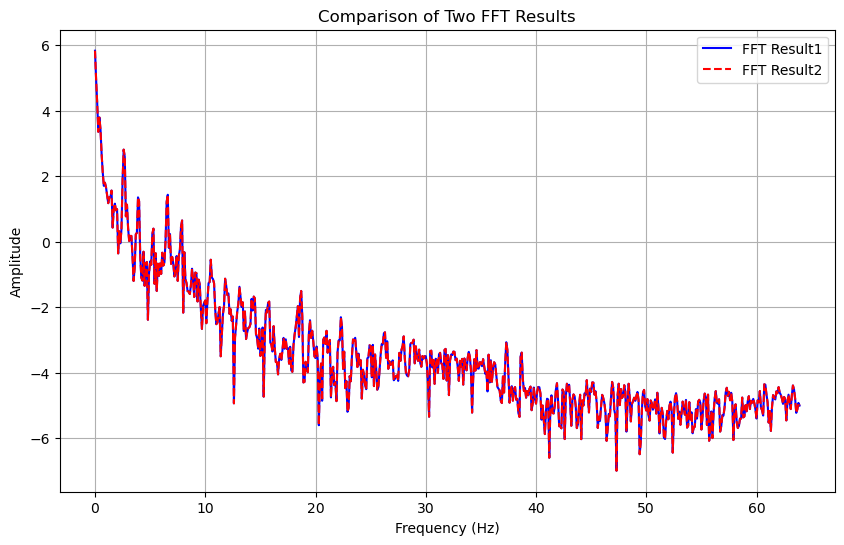

In [8]:
tmp_l, tmp_r = np.fft.fft(wave_l), np.fft.fft(wave_r)
cross_spectrum = tmp_l * np.conj(tmp_r)
magnitude = np.log(np.sqrt(np.abs(cross_spectrum)))

pp.freq_plot(magnitude, spectrum_l, legend=['cross_spectrum', 'left_spectrum'])
pp.freq_plot(magnitude, spectrum_r, legend=['cross_spectrum', 'right_spectrum'])
pp.freq_plot(np.fft.ifft(magnitude).real)
pp.freq_plot(magnitude, (spectrum_l+spectrum_r)/2)

# コヒーレンスとフェーズ

raw\LMH\H003\st_center | data[340 / 403]


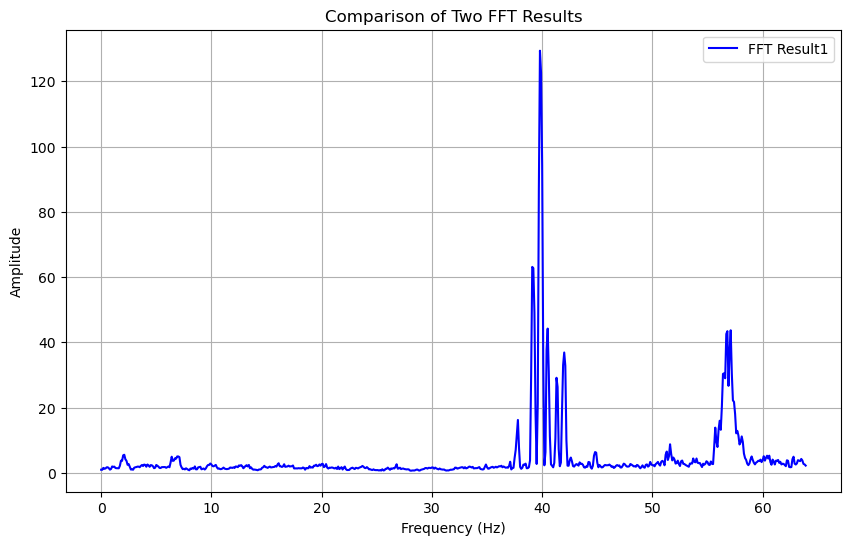

In [9]:
def get_coherence(tester):
    ldata, rdata, _ = pp.slicer(tester.value)
    n_data = 0

    mean_left_spectrum = 0
    mean_right_spectrum = 0
    mean_cross_spectrum = 0

    for left, right in zip(ldata, rdata):
        # 波形の正規化
        left, right = c.normalize(left, right)
        
        # 窓関数を適用
        left *= han
        right *= han

        # FFT
        left_spectrum = np.fft.fft(left)
        right_spectrum = np.fft.fft(right)
        cross_spectrum = left_spectrum * np.conj(right_spectrum)
        
        mean_left_spectrum += np.abs(left_spectrum)**2
        mean_right_spectrum += np.abs(right_spectrum)**2
        mean_cross_spectrum += np.abs(cross_spectrum)**2

        n_data += 1

    mean_left_spectrum /= n_data
    mean_right_spectrum /= n_data
    mean_cross_spectrum /= n_data

    coherence = mean_cross_spectrum / (mean_left_spectrum * mean_right_spectrum)

    return coherence

coherence = get_coherence(tester)
pp.freq_plot(coherence)

# ある区間のスペクトラム比較

c:\ProgramData\Anaconda3\envs\satou\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\ProgramData\Anaconda3\envs\satou\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


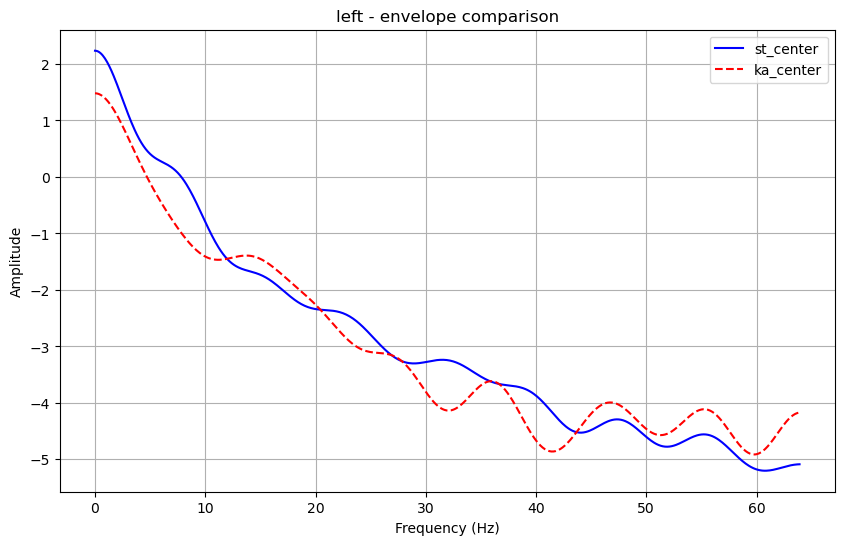

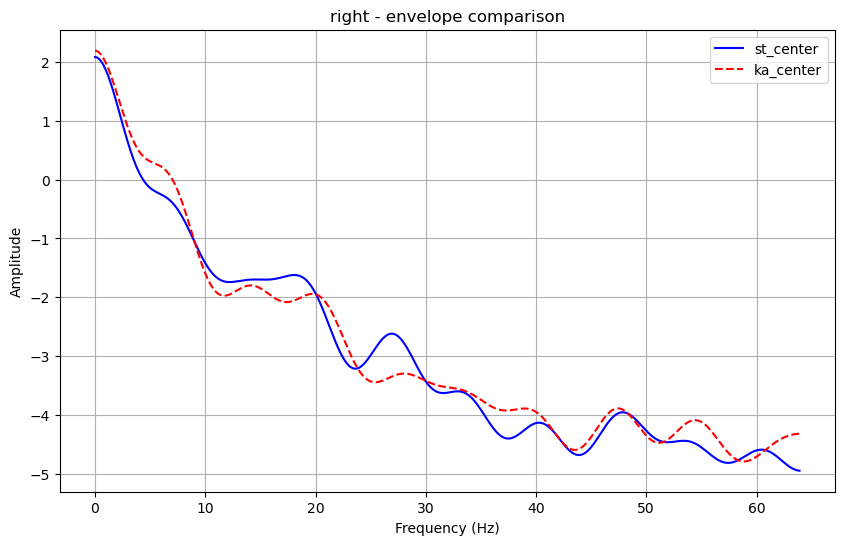

In [10]:
# 被験者データ
tester1 = dpath.LMH.M002.value.st_center
tester2 = dpath.LMH.M002.value.ka_center

cutoff = 20
bandPathLifter = 'low'
scale = 1e-10

def load_csv(tester, start, end):
    wave = pd.read_csv(".."/tester.value/"wave.csv", names=["L", "R", "L_gain", "R_gain"])
    posture = pd.read_csv(".."/tester.value/"position.csv")

    lraw = wave['L'].to_numpy()
    rraw = wave['R'].to_numpy()
    lgain = wave['L_gain'].to_numpy()
    rgain = wave['R_gain'].to_numpy()
    posture = posture.to_numpy()

    left = lraw * 2.818 ** lgain
    right = rraw * 2.818 ** rgain

    left = left[start: end]
    right = right[start: end]
    
    return left, right, posture

# ============= cepstrum1 ============== #
wave_l, wave_r, _ = load_csv(tester1, 128*start, 128*end)
wave_l, wave_r = c.normalize(wave_l, wave_r)
han = np.hanning(len(wave_l))     # ハン窓
wave_l *= han
wave_r *= han
spectrum_l, spectrum_r = np.abs(np.fft.fft(wave_l)), np.abs(np.fft.fft(wave_r))
spectrum_l, spectrum_r = np.log(spectrum_l), np.log(spectrum_r)

# ケプストラムに変換
cepstrum_l = np.fft.ifft(spectrum_l)
cepstrum_r = np.fft.ifft(spectrum_r)

if bandPathLifter == 'high':
    cepstrum_l[:cutoff] *= scale
    cepstrum_l[len(cepstrum_l)-cutoff-1:] *= scale
    cepstrum_r[:cutoff] *= scale
    cepstrum_r[len(cepstrum_l)-cutoff-1:] *= scale
elif bandPathLifter == 'low':
    cepstrum_l[cutoff:len(cepstrum_l)-cutoff+1] *= scale
    cepstrum_r[cutoff:len(cepstrum_r)-cutoff+1] *= scale

cep_to_spectrum_l1 = np.fft.fft(cepstrum_l)
cep_to_spectrum_r1 = np.fft.fft(cepstrum_r)

# ============= cepstrum2 ============== #
wave_l, wave_r, _ = load_csv(tester2, 128*start, 128*end)
wave_l, wave_r = c.normalize(wave_l, wave_r)
han = np.hanning(len(wave_l))     # ハン窓
wave_l *= han
wave_r *= han
spectrum_l, spectrum_r = np.abs(np.fft.fft(wave_l)), np.abs(np.fft.fft(wave_r))
spectrum_l, spectrum_r = np.log(spectrum_l), np.log(spectrum_r)

# ケプストラムに変換
cepstrum_l = np.fft.ifft(spectrum_l)
cepstrum_r = np.fft.ifft(spectrum_r)

if bandPathLifter == 'high':
    cepstrum_l[:cutoff] *= scale
    cepstrum_l[len(cepstrum_l)-cutoff-1:] *= scale
    cepstrum_r[:cutoff] *= scale
    cepstrum_r[len(cepstrum_l)-cutoff-1:] *= scale
elif bandPathLifter == 'low':
    cepstrum_l[cutoff:len(cepstrum_l)-cutoff+1] *= scale
    cepstrum_r[cutoff:len(cepstrum_r)-cutoff+1] *= scale

cep_to_spectrum_l2 = np.fft.fft(cepstrum_l)
cep_to_spectrum_r2 = np.fft.fft(cepstrum_r)

_, _, tester1_mat, _ = dpath.getattributes(tester1, include_position=True)
_, _, tester2_mat, _ = dpath.getattributes(tester2, include_position=True)

pp.freq_plot(cep_to_spectrum_l1, cep_to_spectrum_l2, 128, title='left - envelope comparison', legend=[tester1_mat, tester2_mat])
pp.freq_plot(cep_to_spectrum_r1, cep_to_spectrum_r2, 128, title='right - envelope comparison', legend=[tester1_mat, tester2_mat])

# 平均ケプストラムの比較

raw\LMH\H002\ka_center | data[168 / 223]
raw\LMH\H002\fl_center | data[212 / 238]
ka_center  =  -6.648749849324711e-09
fl_center  =  -6.479267799489928e-09


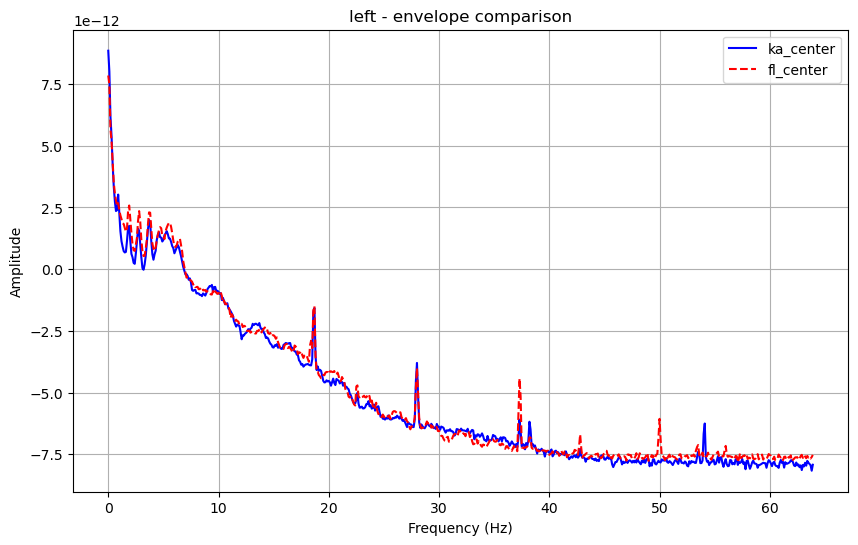

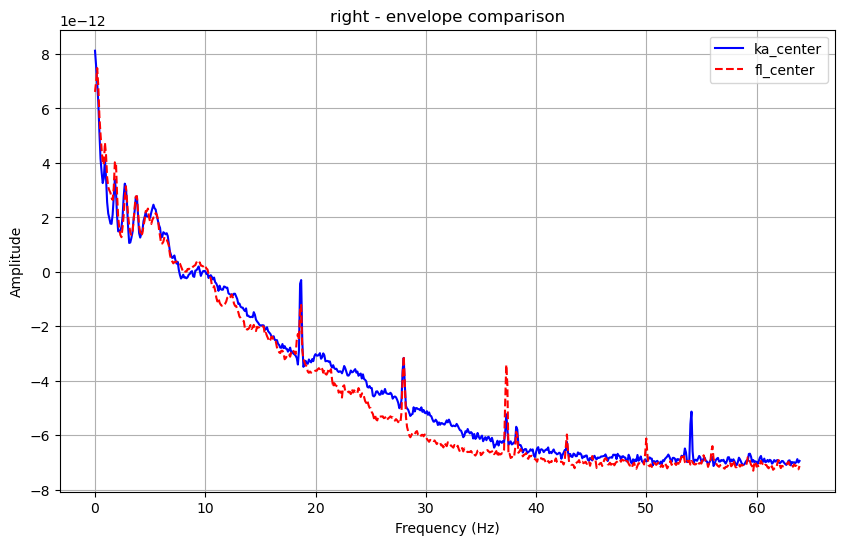

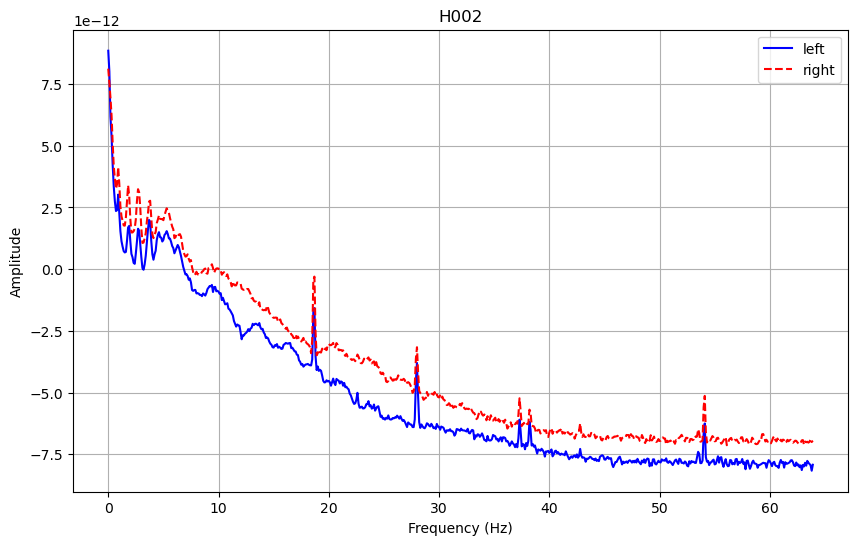

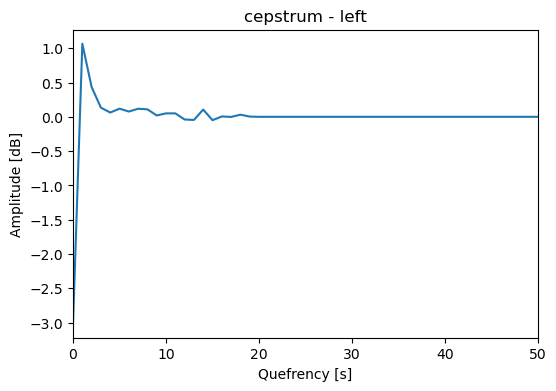

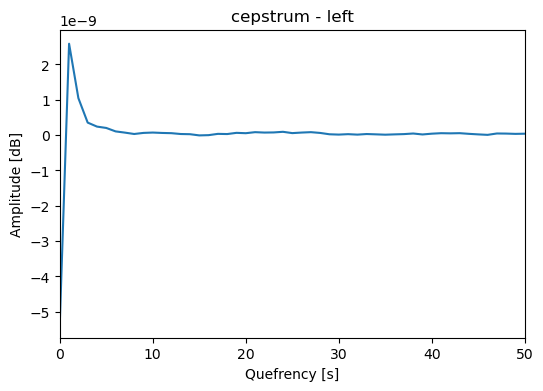

In [11]:
# 被験者データ
tester1 = dpath.LMH.H002.value.ka_center
tester2 = dpath.LMH.H002.value.fl_center

cutoff = 0
bandPathLifter = 'low'
scale = 1e-10

def load_mean_cep(tester):
    ldata, rdata, _ = pp.slicer(tester.value)

    # CMNを適用
    frame = len(ldata[0])
    final_ldata = np.empty((0, frame))
    final_rdata = np.empty((0, frame))

    for left, right in zip(ldata, rdata):
        # 波形の正規化
        left, right = c.normalize(left, right)
        
        # 窓関数を適用
        left *= han
        right *= han

        # FFT
        left_freq = np.fft.fft(left)
        right_freq = np.fft.fft(right)

        # 対数振幅スペクトルに変換
        left_freq = np.log(np.abs(left_freq)) * 20
        right_freq = np.log(np.abs(right_freq)) * 20

        # ケプストラムに変換
        left_cep = np.fft.ifft(left_freq).real
        right_cep = np.fft.ifft(right_freq).real

        # ケプストラムに変換したデータをスタック
        final_ldata = np.vstack((final_ldata, left_cep)) if final_ldata.size else left_cep
        final_rdata = np.vstack((final_rdata, right_cep)) if final_rdata.size else right_cep

    # 平均ケプストラム
    left_cep_mean = np.mean(final_ldata, axis=0)
    right_cep_mean = np.mean(final_rdata, axis=0)
    
    return left_cep_mean, right_cep_mean

cep_l1, cep_r1 = load_mean_cep(tester1)
cep_l2, cep_r2 = load_mean_cep(tester2)

def lifter(cep, cutoff, band, scale):
    if band == 'high':
        cep[:cutoff] *= scale
        cep[len(cepstrum_l)-cutoff-1:] *= scale
    elif band == 'low':
        cep[cutoff:len(cep)-cutoff+1] *= scale
    
    return cep

cep_l1 = lifter(cep_l1, cutoff, bandPathLifter, scale)
cep_r1 = lifter(cep_r1, cutoff, bandPathLifter, scale)
cep_l2 = lifter(cep_l2, cutoff, bandPathLifter, scale)
cep_r2 = lifter(cep_r2, cutoff, bandPathLifter, scale)

cep_to_spectrum_l1 = np.fft.ifft(cep_l1).real
cep_to_spectrum_r1 = np.fft.ifft(cep_r1).real
cep_to_spectrum_l2 = np.fft.ifft(cep_l2).real
cep_to_spectrum_r2 = np.fft.ifft(cep_r2).real

_, tester1_name, tester1_mat, _ = dpath.getattributes(tester1, include_position=True)
_, tester2_name, tester2_mat, _ = dpath.getattributes(tester2, include_position=True)

print(tester1_mat, ' = ', cep_l1[0])
print(tester2_mat, ' = ', cep_l2[0])
pp.freq_plot(cep_to_spectrum_l1, cep_to_spectrum_l2, 128, title='left - envelope comparison', legend=[tester1_mat, tester2_mat])
pp.freq_plot(cep_to_spectrum_r1, cep_to_spectrum_r2, 128, title='right - envelope comparison', legend=[tester1_mat, tester2_mat])

pp.freq_plot(cep_to_spectrum_l1, cep_to_spectrum_r1, 128, title='H002', legend=['left', 'right'])

plt.figure(figsize=(6, 4))
plt.plot(np.arange(0, 1280), cepstrum_l.real - cep_l1)
plt.xlim(0, 50)
plt.title("cepstrum - left")
plt.xlabel('Quefrency [s]')
plt.ylabel('Amplitude [dB]')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(np.arange(0, 1280), cep_r1)
plt.xlim(0, 50)
plt.title("cepstrum - left")
plt.xlabel('Quefrency [s]')
plt.ylabel('Amplitude [dB]')
plt.show()

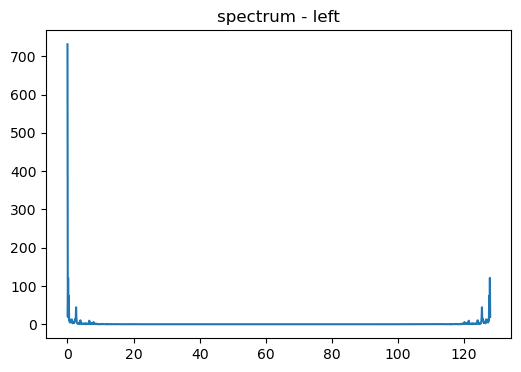

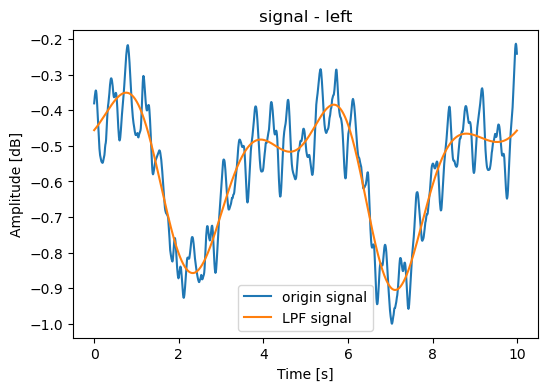

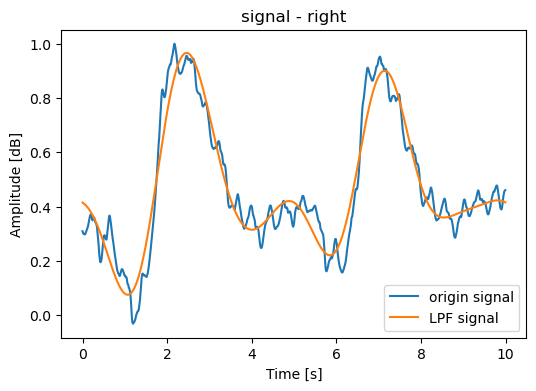

In [12]:
# han = np.hanning(len(wave_l))     # ハン窓
# wave_l *= han
spectrum_l, spectrum_r = np.fft.fft(left_part), np.fft.fft(right_part)

spectrum_l_abs = abs(spectrum_l)
spectrum_r_abs = abs(spectrum_r)

cutoff = 6
bandPathFilter = "low"
if bandPathFilter == 'low':
    spectrum_l[cutoff: len(spectrum_l)-cutoff] *= scale
    spectrum_r[cutoff: len(spectrum_l)-cutoff] *= scale
elif bandPathFilter == 'high':
    spectrum_l[0:cutoff] *= scale
    spectrum_l[len(spectrum_l)-cutoff:len(spectrum_l)-1] *= scale

plt.figure(figsize=(6, 4))
plt.plot(np.arange(0, 128, 0.1), spectrum_l_abs)
plt.title("spectrum - left")
plt.show()

l = np.fft.ifft(spectrum_l).real
r = np.fft.ifft(spectrum_r).real

plt.figure(figsize=(6, 4))
plt.plot(np.arange(0, 10, 1/128), left_part, label='origin signal')
plt.plot(np.arange(0, 10, 1/128), l, label='LPF signal')
plt.title("signal - left")
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [dB]')
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(np.arange(0, 10, 1/128), right_part, label='origin signal')
plt.plot(np.arange(0, 10, 1/128), r, label='LPF signal')
plt.title("signal - right")
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [dB]')
plt.legend()
plt.show()

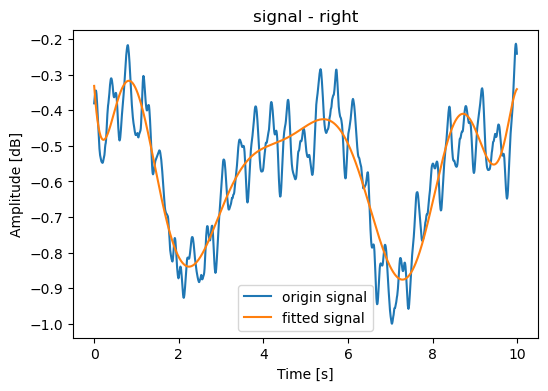

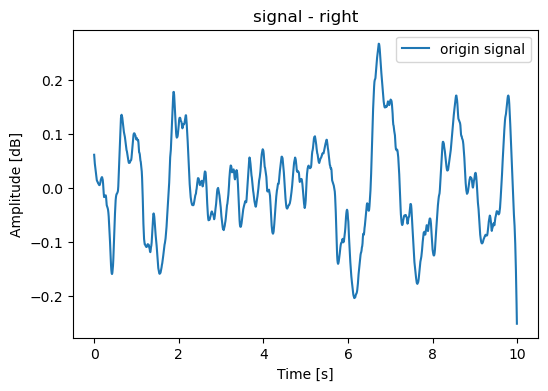

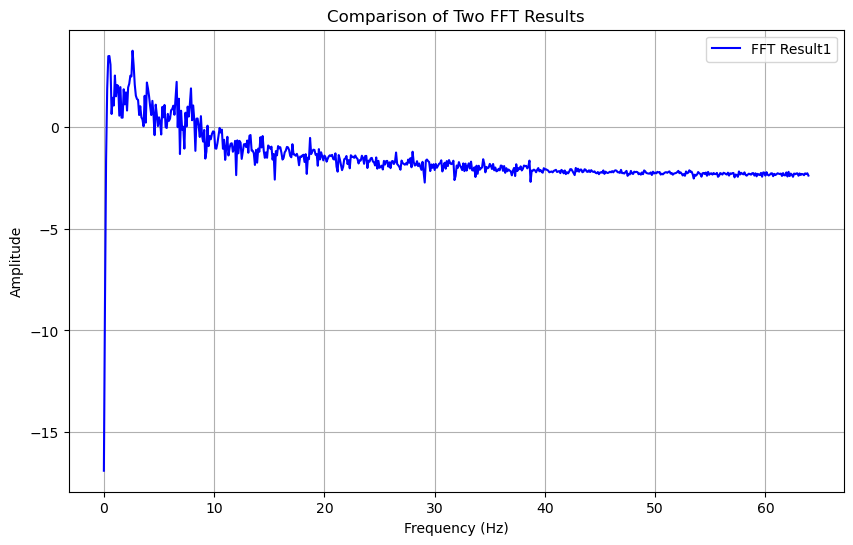

In [13]:
plt.figure(figsize=(6, 4))
plt.plot(np.arange(0, 10, 1/128), left_part, label='origin signal')
plt.plot(np.arange(0, 10, 1/128), pp.fit_polynomial(left_part, 12), label='fitted signal')
plt.title("signal - right")
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [dB]')
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(np.arange(0, 10, 1/128), right_part-pp.fit_polynomial(right_part, 12), label='origin signal')
plt.title("signal - right")
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [dB]')
plt.legend()
plt.show()

nonbreath_spectrum_l = np.log(np.abs(np.fft.fft(left_part-pp.fit_polynomial(left_part, 10))))
nonbreath_spectrum_r = np.log(np.abs(np.fft.fft(right_part-pp.fit_polynomial(right_part, 10))))
pp.freq_plot(nonbreath_spectrum_l)